In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Lambda, Compose, ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
train_dataset = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_dataset = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [4]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

In [5]:
for X, y in test_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 5),    # (28-5+1=24) → 16×24×24
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),   # (24-5+1=20) → 32×20×20
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # → 32×10×10
            nn.Conv2d(32, 64, 5),   # (10-5+1=6) → 64×6×6
            nn.ReLU(),
            nn.MaxPool2d(2, 2)      # → 64×3×3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 3 * 3, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)   # Flatten
        out = self.fc_layer(out)
        return out

model = CNN().to(device)
print(model)

Using cpu device
CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.292424  [    0/60000]
loss: 0.115768  [ 6400/60000]
loss: 0.139793  [12800/60000]
loss: 0.150501  [19200/60000]
loss: 0.075931  [25600/60000]
loss: 0.031603  [32000/60000]
loss: 0.105755  [38400/60000]
loss: 0.068661  [44800/60000]
loss: 0.205153  [51200/60000]
loss: 0.114087  [57600/60000]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.073011 

Epoch 2
-------------------------------
loss: 0.054993  [    0/60000]
loss: 0.097007  [ 6400/60000]
loss: 0.028577  [12800/60000]
loss: 0.047216  [19200/60000]
loss: 0.010036  [25600/60000]
loss: 0.064915  [32000/60000]
loss: 0.051799  [38400/60000]
loss: 0.024719  [44800/60000]
loss: 0.134596  [51200/60000]
loss: 0.059856  [57600/60000]
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.035413 

Epoch 3
-------------------------------
loss: 0.003843  [    0/60000]
loss: 0.072478  [ 6400/60000]
loss: 0.041043  [12800/60000]
loss: 0.002477  [19200/60000]
loss: 0.004299  [25600/60000]
loss: 0.037234  [32000/600

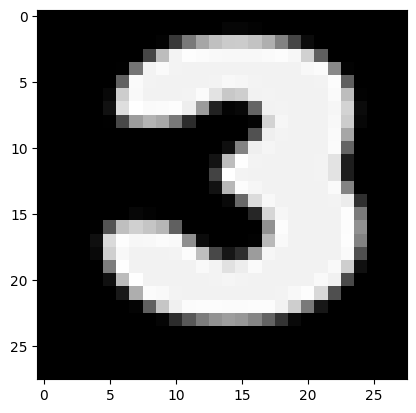

In [11]:
img_path = './image.png'
cur_img = Image.open(img_path)
cur_img = cur_img.resize((28, 28))
image = np.asarray(cur_img)

try:
  image = np.mean(image, axis=2)
except:
  pass

image = np.abs(255-image)
image = image.astype(np.float32)/255.

plt.imshow(image, cmap='gray')
plt.show()

In [12]:
image = torch.as_tensor(image).to(device).reshape(1,1,28,28)
model.eval()
predict = model(image)
print("예측 값은 {} 입니다.".format(predict.argmax(1).item()))

예측 값은 3 입니다.
